In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as modsel
from sklearn.preprocessing import StandardScaler

from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)

data = pd.read_parquet('pump_station_data.parquet')

In [50]:
#----------------------------------Pump 1 RPM limtited time frame model data--------------------------------------
# Optimal for Pump 1 is, for the limited time model, n_tems = 6, ylag = 2, xlag = 5. rrse =  0.27
'''
data = data[:]['2023-02-14 12:27:00':'2023-02-14 14:50:00']    
data_train, data_test = modsel.train_test_split(data, test_size=0.2, shuffle=False)

x_train = data_train['pump1_rpm'].values.reshape(-1,1)                 
y_train = data_train['outflow'].values.reshape(-1,1)

x_test = data_test['pump1_rpm'].values.reshape(-1,1)                    
y_test = data_test['outflow'].values.reshape(-1,1)
'''

#----------------------------------Pump 4 RPM limtited time frame model data--------------------------------------
# Optimal for Pump 4 is, for the limited time model, n_tems = 4, ylag = 2, xlag = 18. rrse =  0.28
'''
data = data[:]['2023-02-14 10:00:00':'2023-02-14 12:20:00']     
data_train, data_test = modsel.train_test_split(data, test_size=0.2, shuffle=False)

x_train = data_train['pump4_rpm'].values.reshape(-1,1)          
y_train = data_train['outflow'].values.reshape(-1,1)

x_test = data_test['pump4_rpm'].values.reshape(-1,1)            
y_test = data_test['outflow'].values.reshape(-1,1)
'''

#----------------------------------Pump 4 and Pump 1 combined RPM model--------------------------------------
# Optimal for Pump 4 is, for the limited time model, n_tems = 6, ylag = 2, xlag = 6. rrse =  0.179

data = data[:]['2023-02-14 10:00:00':'2023-02-14 14:50:00']     
data_train, data_test = modsel.train_test_split(data, test_size=0.2, shuffle=False)

x_train = data_train.drop(labels=['height','outflow', 'pump1_power', 'pump4_power'], axis=1)
x_train = x_train.to_numpy()      
y_train = data_train['outflow'].values.reshape(-1,1)

x_test = data_test.drop(labels=['height','outflow', 'pump1_power', 'pump4_power'], axis=1)
x_test = x_test.to_numpy()        
y_test = data_test['outflow'].values.reshape(-1,1)


In [51]:
# The model is fitted 
basis_function= Polynomial(degree=1)
rrse_low = 2
nt_yl_xl_best = []
yhat_best = []
for nt in range(2,7):
    for yl in range(1,4):
        for xl in range(1,20):
            model = FROLS(
                order_selection=True,
                n_terms = nt,
                extended_least_squares=False,
                ylag=yl,
                xlag=[[1, xl],[1, xl]],
                info_criteria="aic",
                estimator="least_squares",
                basis_function=basis_function,
                )

            model.fit(X=x_train, y=y_train)
            yhat = model.predict(X=x_test,y=y_test)
            rrse = root_relative_squared_error(y_test, yhat)
            print("rrse = ",rrse)
            if rrse < rrse_low:
                rrse_low = rrse
                yhat_best = yhat
                nt_yl_xl_best = [nt,yl,xl]



/home/annetp1000/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)
/home/annetp1000/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/model_structure_selection/forward_regression_orthogonal_least_squares.py:569: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6
  self.info_values = self.information_criterion(reg_matrix, y)
/home/annetp1000/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/parameter_estimation/estima

rrse =  1.0177224633750408
rrse =  1.0155288160368636
rrse =  1.0123274043732755
rrse =  1.0103166709093752
rrse =  1.0115392189573613
rrse =  1.0114982198154792
rrse =  1.0130335157588037
rrse =  1.015658530050238
rrse =  1.0170846248071013
rrse =  1.016653490314143
rrse =  1.0147153749336293
rrse =  1.0135390577528183
rrse =  1.0125498646900366
rrse =  1.0124045709896443
rrse =  1.0122597084392104
rrse =  1.0121152976870649
rrse =  1.0102504151674645
rrse =  1.008417145705299
rrse =  1.009331661559486


/home/annetp1000/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/model_structure_selection/forward_regression_orthogonal_least_squares.py:569: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 7
  self.info_values = self.information_criterion(reg_matrix, y)


rrse =  2.639129586940046
rrse =  2.639129586940046
rrse =  2.782649892024865
rrse =  2.803699390308431
rrse =  2.5977917093856027
rrse =  2.6614383250694273
rrse =  2.542801483645261
rrse =  2.4417452593309923
rrse =  2.4690219530734994
rrse =  2.5476791392897127
rrse =  2.6523603829756013
rrse =  2.6549961086418543
rrse =  2.6717358085664715
rrse =  2.6379553150208257
rrse =  2.641074624328134
rrse =  2.644209512959477
rrse =  2.759479609999268
rrse =  2.816096626368859
rrse =  2.667103580530003
rrse =  2.782649892024865


/home/annetp1000/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/model_structure_selection/forward_regression_orthogonal_least_squares.py:569: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 8
  self.info_values = self.information_criterion(reg_matrix, y)


rrse =  2.782649892024865
rrse =  2.782649892024865
rrse =  2.803699390308431
rrse =  2.5977917093856027
rrse =  2.6614383250694273
rrse =  2.542801483645261
rrse =  2.4417452593309923
rrse =  2.4690219530734994
rrse =  2.5476791392897127
rrse =  2.6523603829756013
rrse =  2.6549961086418543
rrse =  2.6717358085664715
rrse =  2.6379553150208257
rrse =  2.641074624328134
rrse =  2.644209512959477
rrse =  2.759479609999268
rrse =  2.816096626368859
rrse =  2.667103580530003
rrse =  1.1415041560308048
rrse =  1.1382509881044234
rrse =  1.1340590263137025
rrse =  1.1315772688000296
rrse =  1.133350628494165
rrse =  1.1332216403436763
rrse =  1.1349849468902393
rrse =  1.1384602175385885
rrse =  1.1409153844442703
rrse =  1.1410551816020327
rrse =  1.1396517399228976
rrse =  1.138753817913696
rrse =  1.1377298533057831
rrse =  1.1375353815508178
rrse =  1.1373319669230142
rrse =  1.1371195605859905
rrse =  1.1346531976232188
rrse =  1.1321720027671913
rrse =  1.1333494775090514
rrse =  1.02

In [52]:
print(nt_yl_xl_best)
print(rrse_low)

[6, 2, 6]
0.1795857790623754


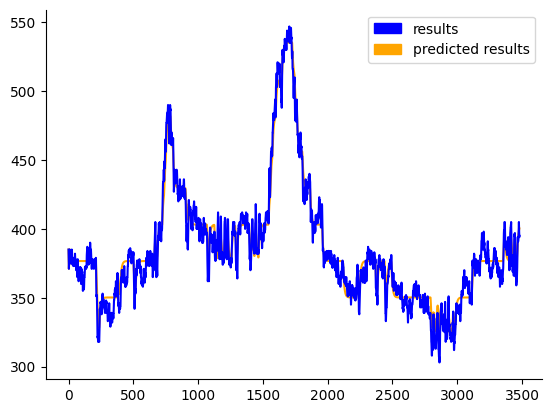

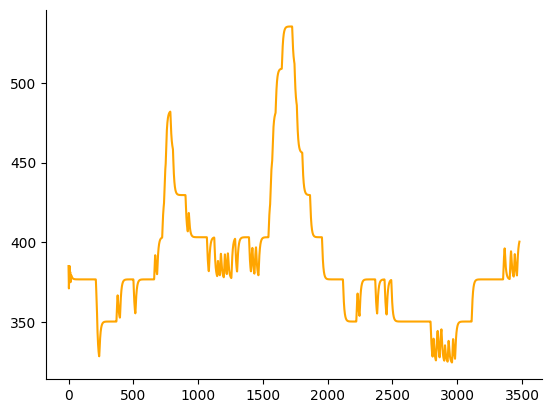

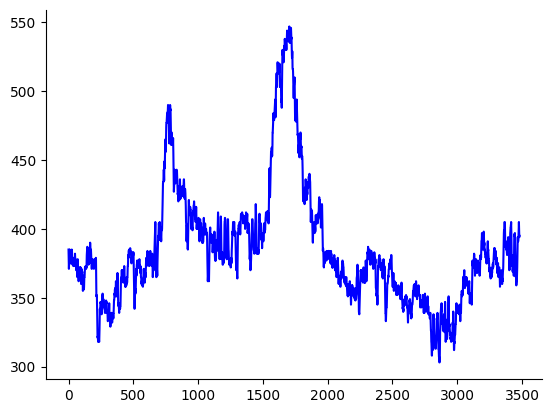

In [53]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots()
ax.plot(yhat, color='orange')
ax.plot(y_test, color='blue')
orange_patch = mpatches.Patch(color='orange', label='predicted results')
blue_patch = mpatches.Patch(color='blue', label='results')
ax.legend(handles=[blue_patch,orange_patch])

plt.show()


plt.plot(yhat, color='orange')
plt.show()

plt.plot(y_test, color='blue')
plt.show()